# Mosquito

## Stochastic model

Here, the model is simplified, with only the eggs and adults, where adults can be female, male or sterile male.

Mating rate :$$ \xi(M) = \frac{\alpha M}{1 + \alpha M} .$$

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [92]:
# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.8      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
egg_death = 0.2     # Death rate per egg
adult_death = 0.2     # Death rate per adult
sterile_death = 0.3   # Death rate per sterile
init_egg = 0  # Starting egg population
init_female = 100 # Starting female population
init_male = 5 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp_egg = 1/500 # Carrying capacity

# Initialize variables
egg_pop = init_egg
male_pop = init_male
female_pop = init_female
sterile_pop = init_sterile
sterile_hist = 0
t = 0.0
time_history = [t]
pop = np.array([egg_pop, female_pop, male_pop, sterile_pop], dtype=int)
population_history = [(egg_pop, female_pop, male_pop, sterile_pop)]
Mat_events = np.array([[30, -1, 0, 0],
              [-1, 0, 0, 0],
              [0,-1, 0, 0],
              [0, 0, -1, 0],
              [-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [0, 0, 0, -1]], dtype=np.int8)

In [90]:
def mating(M, Ms):
    return 0.5 * M / (1 + 0.5 * M + 0.4 * Ms)

In [66]:
def event(i, state, M_event):
    return state + M_event[i]

In [67]:
def release1(M, n):
    return n*M + 1000

In [7]:
def release2(M):
    return 0

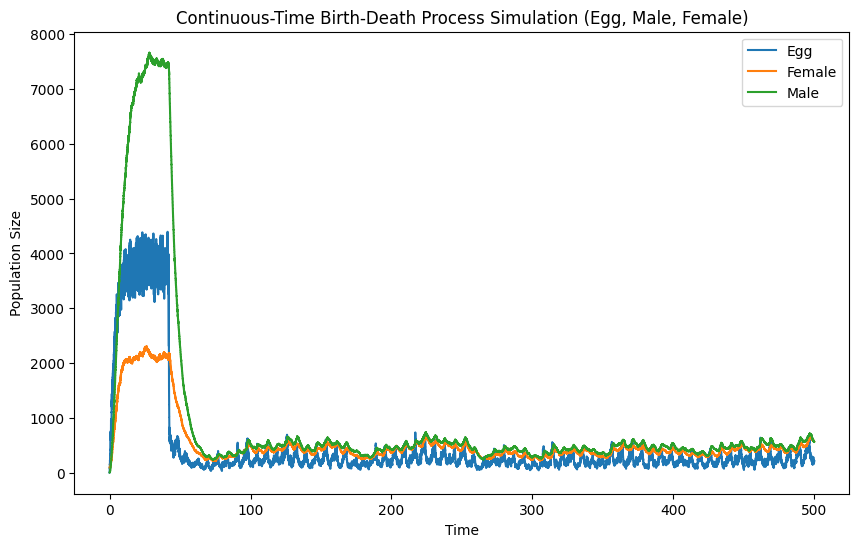

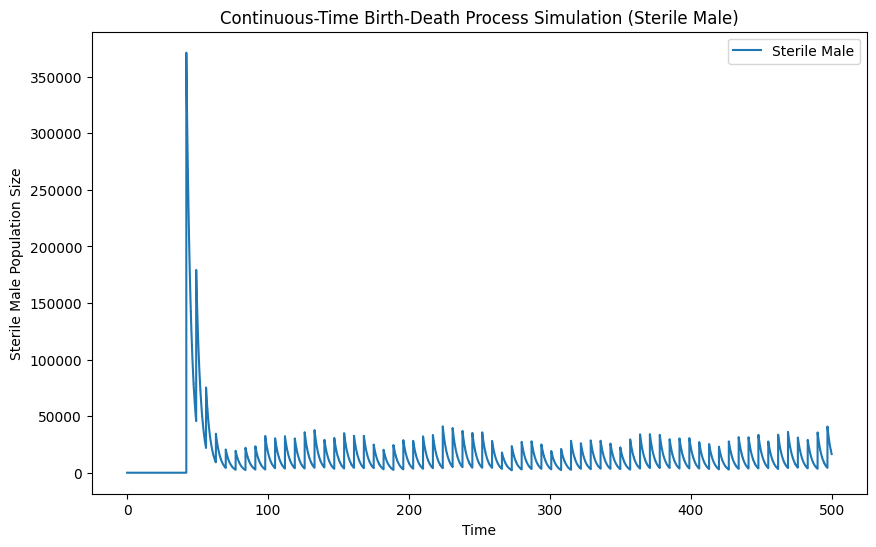

Total sterile insects released:  2189350


In [ ]:
# Simulation loop
while time < max_time and ( pop[1] + pop[2] > 0):

    # Total rate for any event to happen (birth or death)
    rate_matrix = np.array([birth * mating(pop[2], pop[3]) * pop[1], 
                   (egg_death + comp_egg * pop[0]) * pop[0], 
                   adult_death * pop[1],
                   adult_death * pop[2], 
                   mu * puberty * pop[0], 
                   (1-mu) * puberty * pop[0], 
                   sterile_death * pop[3]])
    
 #    total_rate = birth * mating(male_pop, sterile_pop) * female_pop + (egg_death + comp_egg * egg_pop) * egg_pop + adult_death * male_pop + adult_death * female_pop + mu * puberty * egg_pop + (1-mu) * puberty * egg_pop + sterile_death * sterile_pop
    total_rate = sum(rate_matrix)

    # Draw the time to the next event from an exponential distribution
    time_to_next_event = np.random.exponential(1 / total_rate)
    time += time_to_next_event
    # Release sterile insects
    if int(time) % 7 == 0 and (len(time_history) == 0 or int(time_history[-1]) != int(time)) and time > 40:
        new_release = release1(pop[2], 50)
        pop[3] += new_release
        sterile_hist += new_release

    # Determine the event that will happen
    n_event = np.random.choice(range(7), p=np.array(rate_matrix)/total_rate)
    
    pop += Mat_events[n_event]

    # Record time and population
    time_history.append(time)
    population_history.append(pop)

# Plot results for male, female, and egg population
plt.figure(figsize=(10, 6))
plt.step(time_history, [k[0] for k in population_history], where="post", label='Egg')
plt.step(time_history, [k[1] for k in population_history], where="post", label='Female')
plt.step(time_history, [k[2] for k in population_history], where="post", label='Male')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.legend()
plt.show()

# Plot results for sterile male population
plt.figure(figsize=(10, 6))
plt.step(time_history, [k[3] for k in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()

print("Total sterile insects released: ", sterile_hist)

## Two island model

Immigration is taken into account now. The model is the same as before, where the only difference is that the population is divided into two islands.

In [17]:
# Immigration parameters
imm = 0.1

In [34]:
# Simulation loop
while time < max_time and ( egg_pop + male_pop + female_pop > 0):

    # Total rate for any event to happen (birth or death)
    total_rate = birth * max((1 - egg_pop/K), 0) * mating(male_pop, sterile_pop) * female_pop + egg_death * egg_pop + adult_death * male_pop + adult_death * female_pop + mu * puberty * egg_pop + (1-mu) * puberty * egg_pop + sterile_death * sterile_pop

    # Draw the time to the next event from an exponential distribution
    time_to_next_event = np.random.exponential(1 / total_rate)
    time += time_to_next_event

    # Release sterile insects
    if int(time) % 7 == 0 and (len(time_history) == 0 or int(time_history[-1]) != int(time)) and time > 40:
        sterile_pop += release1(male_pop, 20)

    # Determine the event that will happen
    p = np.random.rand()
    
    # Birth
    if p < (birth * max((1 - egg_pop/K), 0) * mating(male_pop, sterile_pop) * female_pop) / total_rate:
        egg_pop += 10
        female_pop -= 1

    # Transition to female
    elif p < (puberty * mu * egg_pop + birth * max((1 - egg_pop/K), 0) * mating(male_pop, sterile_pop) * female_pop) / total_rate and egg_pop > 0:
        egg_pop -= 1
        female_pop += 1

    # Transition to male
    elif p < (puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth * max((1 - egg_pop/K), 0) * mating(male_pop, sterile_pop) * female_pop) / total_rate and egg_pop > 0:
        egg_pop -= 1
        male_pop += 1

    # Child death
    elif p < ( egg_death * egg_pop + puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth * max((1 - egg_pop/K), 0) * mating(male_pop, sterile_pop) * female_pop) / total_rate and egg_pop > 0:
        egg_pop -= 1

    # Adult death
    elif p < (adult_death * female_pop + egg_death * egg_pop + puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth * max((1 - egg_pop/K), 0) * mating(male_pop, sterile_pop) * female_pop) / total_rate:
        female_pop -= 1

    elif p < (adult_death * (female_pop + male_pop) + egg_death * egg_pop + puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth * max((1 - egg_pop/K), 0) * mating(male_pop, sterile_pop) * female_pop) / total_rate:
        male_pop -= 1

    # Sterile death
    else:
        sterile_pop -= 1

    # Record time and population
    time_history.append(time)
    population_history.append((egg_pop, male_pop, female_pop, sterile_pop))

# Plot results for male, female, and egg population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[0] for pop in population_history], where="post", label='Egg')
plt.step(time_history, [pop[1] for pop in population_history], where="post", label='Male')
plt.step(time_history, [pop[2] for pop in population_history], where="post", label='Female')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.legend()
plt.show()

# Plot results for sterile male population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[3] for pop in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()


TypeError: '<' not supported between instances of 'module' and 'float'

## Benchmarking the models ?

Step 1 (Rate calculation) - Total: 51.720779s, Average: 0.000026s
Step 2 (Time to next event) - Total: 3.367752s, Average: 0.000002s
Step 3 (Sterile release) - Total: 0.900568s, Average: 0.000000s
Step 4 (Determine event) - Total: 19.509064s, Average: 0.000010s
Step 5 (Record history) - Total: 0.616539s, Average: 0.000000s
len(time_history):  1987308


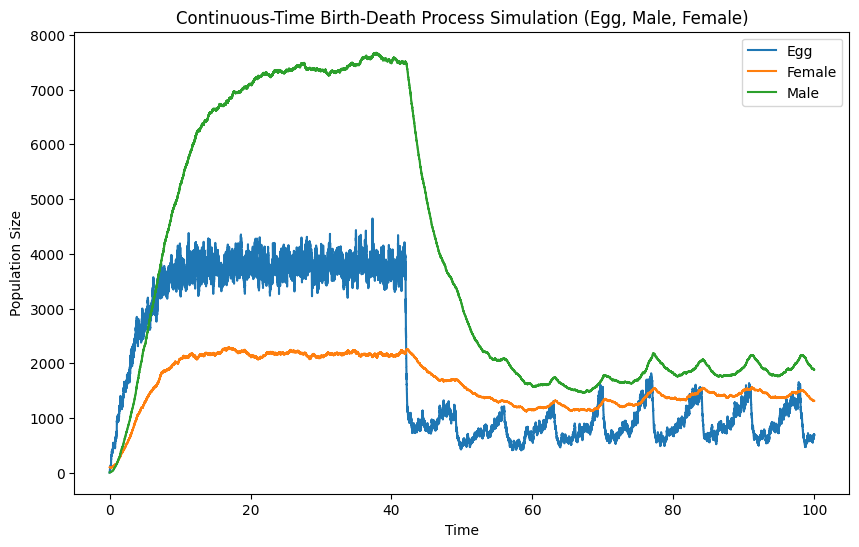

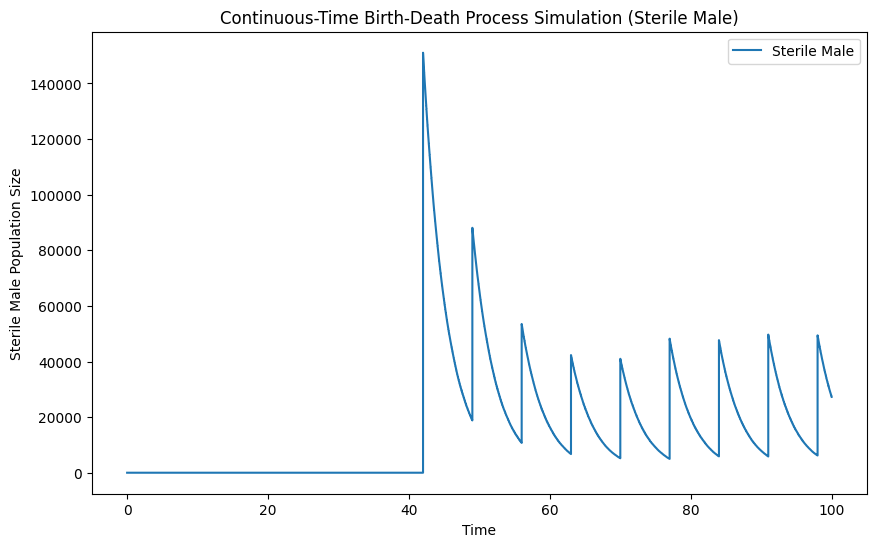

Total sterile insects released:  506580


In [ ]:
import time

t = 0.0
step1_durations = []
step2_durations = []
step3_durations = []
step4_durations = []
step5_durations = []

while t < 100 and (pop[1] + pop[2] > 0):
    # Étape 1 : Calcul du taux total
    start_step1 = time.time()
    rate_matrix = np.array([
        birth * mating(pop[2], pop[3]) * pop[1],
        (egg_death + comp_egg * (pop[0] - 1)) * pop[0],
        adult_death * pop[1],
        adult_death * pop[2],
        mu * puberty * pop[0],
        (1 - mu) * puberty * pop[0],
        sterile_death * pop[3]
    ], dtype=float)
    total_rate = np.sum(rate_matrix)
    end_step1 = time.time()
    step1_durations.append(end_step1 - start_step1)

    # Étape 2 : Dessiner le temps jusqu'au prochain événement
    start_step2 = time.time()
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event
    end_step2 = time.time()
    step2_durations.append(end_step2 - start_step2)

    # Étape 3 : Relâchement des insectes stériles
    start_step3 = time.time()
    if (
        int(t) % 7 == 0
        and (len(time_history) == 0 or int(time_history[-1]) != int(t))
        and t > 40
    ):
        new_release = release1(pop[2], 20)
        pop[3] += new_release
        sterile_hist += new_release
    end_step3 = time.time()
    step3_durations.append(end_step3 - start_step3)

    # Étape 4 : Evenement
    start_step4 = time.time()
    cumulative_probabilities = np.cumsum(rate_matrix / total_rate)

    # Draw a random number
    r = np.random.rand()

    # Find the event using binary search
    n_event = np.searchsorted(cumulative_probabilities, r,side = 'left')
    pop = np.add(pop, Mat_events[n_event])
    end_step4 = time.time()
    step4_durations.append(end_step4 - start_step4)

    # Étape 5 : Enregistrement de l'historique
    start_step5 = time.time()
    time_history.append(t)
    population_history.append(pop)
    end_step5 = time.time()
    step5_durations.append(end_step5 - start_step5)

# Résultats : Durées totales et moyennes pour chaque étape
num_iterations = len(time_history)

total_time_step1 = sum(step1_durations)
total_time_step2 = sum(step2_durations)
total_time_step3 = sum(step3_durations)
total_time_step4 = sum(step4_durations)
total_time_step5 = sum(step5_durations)

avg_time_step1 = total_time_step1 / num_iterations
avg_time_step2 = total_time_step2 / num_iterations
avg_time_step3 = total_time_step3 / num_iterations
avg_time_step4 = total_time_step4 / num_iterations
avg_time_step5 = total_time_step5 / num_iterations

print(f"Step 1 (Rate calculation) - Total: {total_time_step1:.6f}s, Average: {avg_time_step1:.6f}s")
print(f"Step 2 (Time to next event) - Total: {total_time_step2:.6f}s, Average: {avg_time_step2:.6f}s")
print(f"Step 3 (Sterile release) - Total: {total_time_step3:.6f}s, Average: {avg_time_step3:.6f}s")
print(f"Step 4 (Determine event) - Total: {total_time_step4:.6f}s, Average: {avg_time_step4:.6f}s")
print(f"Step 5 (Record history) - Total: {total_time_step5:.6f}s, Average: {avg_time_step5:.6f}s")
print("len(time_history): ", len(time_history))
# Graphiques des populations
plt.figure(figsize=(10, 6))
plt.step(time_history, [k[0] for k in population_history], where="post", label='Egg')
plt.step(time_history, [k[1] for k in population_history], where="post", label='Female')
plt.step(time_history, [k[2] for k in population_history], where="post", label='Male')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.step(time_history, [k[3] for k in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()

print("Total sterile insects released: ", sterile_hist)

Step 1 (Rate calculation) - Total: 7.189015s, Average: 0.000001s
Step 2 (Time to next event) - Total: 6.930566s, Average: 0.000001s
Step 3 (Sterile release) - Total: 2.082639s, Average: 0.000000s
Step 4 (Determine event) - Total: 27.017397s, Average: 0.000005s
Step 5 (Record history) - Total: 2.206176s, Average: 0.000000s
len(time_history):  5871555


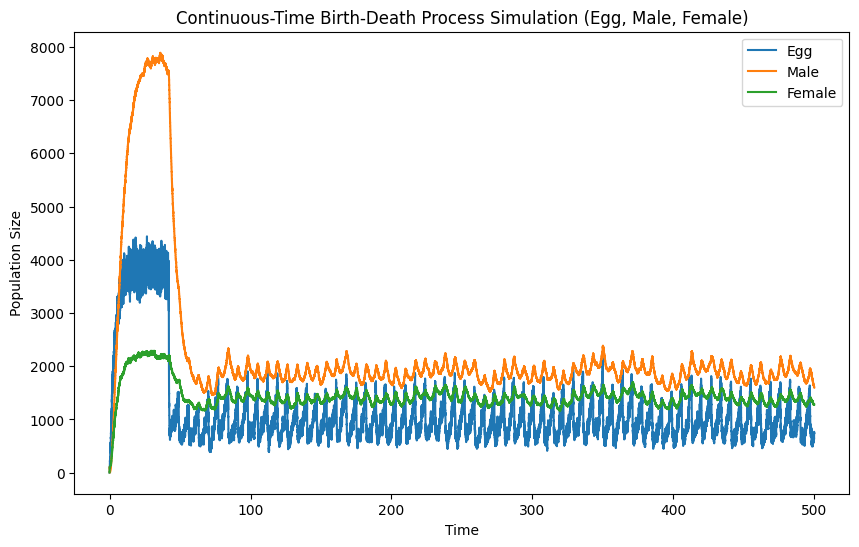

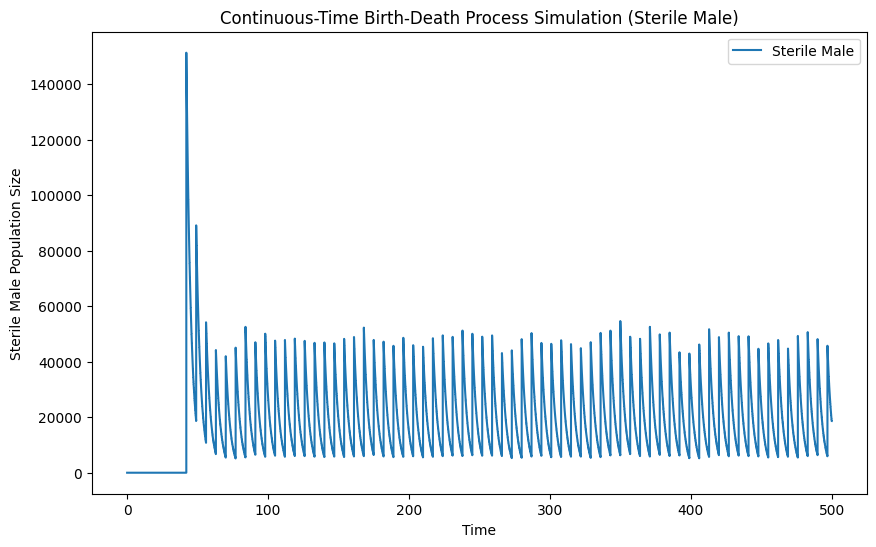

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Assumptions: `mating()`, `release1()`, and all other required parameters (e.g., `birth`, `K`, `egg_death`) are defined.
# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.8      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
egg_death = 0.2     # Death rate per egg
adult_death = 0.2     # Death rate per adult
sterile_death = 0.3   # Death rate per sterile
init_egg = 0  # Starting egg population
init_female = 100 # Starting female population
init_male = 5 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp_egg = 1/500 # Carrying capacity

# Initialize variables
egg_pop = init_egg
male_pop = init_male
female_pop = init_female
sterile_pop = init_sterile
sterile_hist = 0
t = 0.0
time_history = [t]
pop = np.array([egg_pop, female_pop, male_pop, sterile_pop], dtype=int)
population_history = [(egg_pop, female_pop, male_pop, sterile_pop)]
Mat_events = np.array([[30, -1, 0, 0],
              [-1, 0, 0, 0],
              [0,-1, 0, 0],
              [0, 0, -1, 0],
              [-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [0, 0, 0, -1]], dtype=np.int8)

# Timing for each step
step1_durations = []  # Total rate calculation
step2_durations = []  # Time to next event
step3_durations = []  # Sterile insect release
step4_durations = []  # Event determination
step5_durations = []  # Record history

while t < max_time and (egg_pop + male_pop + female_pop > 0):
    # Step 1: Calculate total rate
    start_step1 = time.time()
    total_rate = (
        birth * mating(male_pop, sterile_pop) * female_pop +
        (egg_death + comp_egg * egg_pop) * egg_pop+
        adult_death * male_pop +
        adult_death * female_pop +
        mu * puberty * egg_pop +
        (1 - mu) * puberty * egg_pop +
        sterile_death * sterile_pop
    )
    end_step1 = time.time()
    step1_durations.append(end_step1 - start_step1)

    # Step 2: Draw time to next event
    start_step2 = time.time()
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event
    end_step2 = time.time()
    step2_durations.append(end_step2 - start_step2)


    # Step 4: Determine the event
    start_step4 = time.time()
    p = np.random.rand()

    if p < (birth * mating(male_pop, sterile_pop) * female_pop) / total_rate:
        egg_pop += 30
        female_pop -= 1
    elif p < (puberty * mu * egg_pop + birth * mating(male_pop, sterile_pop) * female_pop) / total_rate and egg_pop > 0:
        egg_pop -= 1
        female_pop += 1
    elif p < (puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth * mating(male_pop, sterile_pop) * female_pop) / total_rate and egg_pop > 0:
        egg_pop -= 1
        male_pop += 1
    elif p < ((egg_death + comp_egg * egg_pop) * egg_pop + puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth * mating(male_pop, sterile_pop) * female_pop) / total_rate and egg_pop > 0:
        egg_pop -= 1
    elif p < (adult_death * female_pop + (egg_death + comp_egg * egg_pop) * egg_pop  + puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth * mating(male_pop, sterile_pop) * female_pop) / total_rate:
        female_pop -= 1
    elif p < (adult_death * (female_pop + male_pop) + (egg_death + comp_egg * egg_pop) * egg_pop  + puberty * (1 - mu) * egg_pop + puberty * mu * egg_pop + birth  * mating(male_pop, sterile_pop) * female_pop) / total_rate:
        male_pop -= 1
    else:
        sterile_pop -= 1
    end_step4 = time.time()
    step4_durations.append(end_step4 - start_step4)

    # Step 3: Sterile insect release
    start_step3 = time.time()
    if int(t) % 7 == 0 and (len(time_history) == 0 or int(time_history[-1]) != int(t)) and t > 40:
        sterile_pop += release1(male_pop, 100)
    end_step3 = time.time()
    step3_durations.append(end_step3 - start_step3)

    # Step 5: Record history
    start_step5 = time.time()
    time_history.append(t)
    population_history.append((egg_pop, male_pop, female_pop, sterile_pop))
    end_step5 = time.time()
    step5_durations.append(end_step5 - start_step5)

# Calculate total and average durations for each step
num_iterations = len(time_history)

total_time_step1 = sum(step1_durations)
total_time_step2 = sum(step2_durations)
total_time_step3 = sum(step3_durations)
total_time_step4 = sum(step4_durations)
total_time_step5 = sum(step5_durations)

avg_time_step1 = total_time_step1 / num_iterations
avg_time_step2 = total_time_step2 / num_iterations
avg_time_step3 = total_time_step3 / num_iterations
avg_time_step4 = total_time_step4 / num_iterations
avg_time_step5 = total_time_step5 / num_iterations

# Print the results
print(f"Step 1 (Rate calculation) - Total: {total_time_step1:.6f}s, Average: {avg_time_step1:.6f}s")
print(f"Step 2 (Time to next event) - Total: {total_time_step2:.6f}s, Average: {avg_time_step2:.6f}s")
print(f"Step 3 (Sterile release) - Total: {total_time_step3:.6f}s, Average: {avg_time_step3:.6f}s")
print(f"Step 4 (Determine event) - Total: {total_time_step4:.6f}s, Average: {avg_time_step4:.6f}s")
print(f"Step 5 (Record history) - Total: {total_time_step5:.6f}s, Average: {avg_time_step5:.6f}s")
print("len(time_history): ", len(time_history))

# Plot results for male, female, and egg population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[0] for pop in population_history], where="post", label='Egg')
plt.step(time_history, [pop[1] for pop in population_history], where="post", label='Male')
plt.step(time_history, [pop[2] for pop in population_history], where="post", label='Female')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.legend()
plt.show()

# Plot results for sterile male population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[3] for pop in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()


In [84]:

print("len(time_history): ", len(time_history))

len(time_history):  197954
